In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint

import torch
import pickle
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import glob

from pose_est import brute_force_pose_est
import postprocess_dataset
from utils import utils

In [4]:
# displays meshes at the predicted pose
def show_meshes(input_dir_img, input_dir_mesh, meshes_group_name="", use_meshes=None):
    pred_poses_path = os.path.join(input_dir_mesh, "pred_poses.p")
    cached_pred_poses = pickle.load(open(pred_poses_path, "rb"))

    for instance_name in cached_pred_poses:
        if use_meshes is None or instance_name in use_meshes:
            input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
            with torch.no_grad():
                mesh_original = utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
                mesh_processed = utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+"_{}.obj".format(meshes_group_name)), device)

            # rendering original and processed mesh at predicted pose
            pred_dist = cached_pred_poses[instance_name]['dist']
            pred_elev = cached_pred_poses[instance_name]['elev']
            pred_azim = cached_pred_poses[instance_name]['azim']
            R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
            mesh_original_render = utils.render_mesh(mesh_original, R, T, device)
            mesh_processed_render = utils.render_mesh(mesh_processed, R, T, device)

            # visualizing
            print(instance_name)
            fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False)
            ax[0][0].imshow(input_image)
            ax[0][0].xaxis.set_visible(False)
            ax[0][0].yaxis.set_visible(False)

            ax[0][1].imshow(mesh_original_render[0, ..., :3].cpu().numpy())
            ax[0][1].xaxis.set_visible(False)
            ax[0][1].yaxis.set_visible(False)

            ax[0][2].imshow(mesh_processed_render[0, ..., :3].cpu().numpy())
            ax[0][2].xaxis.set_visible(False)
            ax[0][2].yaxis.set_visible(False)
            plt.pause(0.05)

In [5]:
input_dir_img = "data/test_dataset/"
input_dir_mesh = "data/test_dataset/"
cfg_path = "configs/default.yaml"
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
experiment_name = "test"
use_meshes = None
#use_meshes = ['3704']

In [14]:
dataset_loss_info = postprocess_dataset.postprocess_data(input_dir_img, input_dir_mesh, cfg_path, gpu_num, meshes_group_name=experiment_name,
                                                         recompute_poses=False, meshes_to_render=use_meshes)

/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:51: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_special = yaml.load(f)


{'model': {'latent_dim_pointnet': 512, 'latent_dim_resnet': 256},
 'semantic_dis_training': {'epochs': 20,
                           'eval_every': 5,
                           'fake_dataset_dir': 'data/semantic_dis/fake_renders',
                           'real_dataset_dir': 'data/semantic_dis/real_renders',
                           'weight_path': 'deformation/semantic_dis_net_weights.pt'},
 'training': {'img_sym_lam': 100,
              'img_sym_num_azim': 1,
              'l2_lam': 1,
              'lap_lam': 10,
              'learning_rate': 1e-05,
              'normals_lam': 10,
              'num_iterations': 600,
              'semantic_dis_lam': 0,
              'semantic_dis_num_render': 3,
              'sil_lam': 20,
              'vertex_sym_lam': 0.1}}


KeyboardInterrupt: 

3704


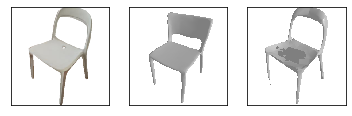

In [17]:
# show postprocessed meshes at predicted angle
show_meshes(input_dir_img, input_dir_mesh, experiment_name, use_meshes)

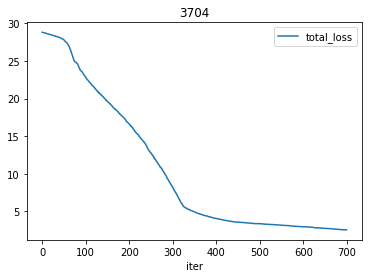

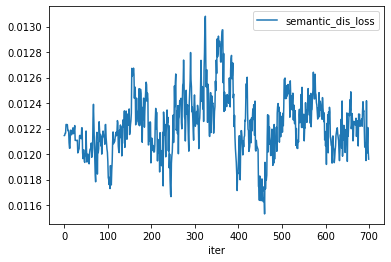

In [15]:
# show training loss info
for instance_name in dataset_loss_info:
    loss_info = dataset_loss_info[instance_name]
    loss_info.plot.line(x='iter', y='total_loss', title="{}".format(instance_name))
    #loss_info.plot.line(x='iter', y='sil_loss')
    #loss_info.plot.line(x='iter', y='img_sym_loss')
    #loss_info.plot.line(x='iter', y='vertex_sym_loss')
    #loss_info.plot.line(x='iter', y='l2_loss')
    #loss_info.plot.line(x='iter', y='lap_smoothness_loss')
    #loss_info.plot.line(x='iter', y='normal_consistency_loss')
    loss_info.plot.line(x='iter', y='semantic_dis_loss')